# AI Classroom Assistant - Attention Detection using MPIIGaze

In [11]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset
import pandas as pd
from tqdm import tqdm
import time
from datetime import timedelta


In [2]:
# Configuration
DATA_DIR = r'D:\\Smart_EDU\\MPIIGaze\\Data\\Original'
LABELS_FILE = r'D:\\Smart_EDU\\MPIIGaze\\labels.csv'
EPOCHS = 10
PATIENCE = 4
BATCH_SIZE = 32
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Dataset Class
class GazeDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = default_loader(img_path)
        label = torch.tensor(self.annotations.iloc[idx, 1:].values.astype(np.float32))
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = GazeDataset(LABELS_FILE, DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# Model
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)  # Assuming 2D gaze
model = model.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training with Early Stopping, Resume capability, and Metrics

def save_checkpoint(epoch, model, optimizer, train_losses, val_losses, best_loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_loss': best_loss
    }, 'checkpoint.pt')

# Try to load checkpoint if exists
start_epoch = 0
if os.path.exists('checkpoint.pt'):
    checkpoint = torch.load('checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    best_loss = checkpoint['best_loss']
else:
    train_losses, val_losses = [], []
    best_loss = float('inf')

patience_counter = 0
for epoch in range(start_epoch, EPOCHS):
    epoch_start_time = time.time()
    
    # Training phase
    model.train()
    running_loss = 0
    train_correct = 0
    train_total = 0
    train_start_time = time.time()
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy (considering predictions within a threshold)
        threshold = 10  # degrees
        diff = torch.abs(outputs - labels)
        correct = (diff <= threshold).all(dim=1).sum().item()
        train_correct += correct
        train_total += inputs.size(0)
        
        # Print epoch progress
        current_train_acc = 100 * train_correct / train_total
        elapsed_time = time.time() - epoch_start_time
        remaining_time = (elapsed_time / (batch_idx + 1)) * (len(train_loader) - batch_idx - 1)
        print(f'Epoch [{epoch+1}/{EPOCHS}] | '
              f'Progress: {(batch_idx + 1)*100/len(train_loader):.1f}% | '
              f'Loss: {loss.item():.4f} | '
              f'Accuracy: {current_train_acc:.2f}% | '
              f'Time: {timedelta(seconds=int(elapsed_time))} / ETA: {timedelta(seconds=int(remaining_time))}', end='\r')
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_time = time.time() - train_start_time

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            diff = torch.abs(outputs - labels)
            correct = (diff <= threshold).all(dim=1).sum().item()
            val_correct += correct
            val_total += inputs.size(0)
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_time = time.time() - val_start_time
    
    # Save losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch statistics with clear formatting
    print('\n' + '='*80)
    print(f"Epoch [{epoch+1}/{EPOCHS}] completed in {timedelta(seconds=int(epoch_time))}")
    print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}% ({train_correct}/{train_total})")
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}% ({val_correct}/{val_total})")
    print(f"Time: Total: {timedelta(seconds=int(epoch_time))}, Train: {timedelta(seconds=int(train_time))}, Val: {timedelta(seconds=int(val_time))}")
    
    # Save checkpoint after each epoch
    save_checkpoint(epoch, model, optimizer, train_losses, val_losses, best_loss)

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print("✓ Saved new best model")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print('Early stopping triggered.')
            break
    print('='*80)

In [ ]:
# Evaluation
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
preds, true_vals = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs).cpu().numpy()
        preds.extend(outputs)
        true_vals.extend(labels.numpy())

mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)
print(f"RMSE: {rmse:.4f}, R^2: {r2:.4f}")


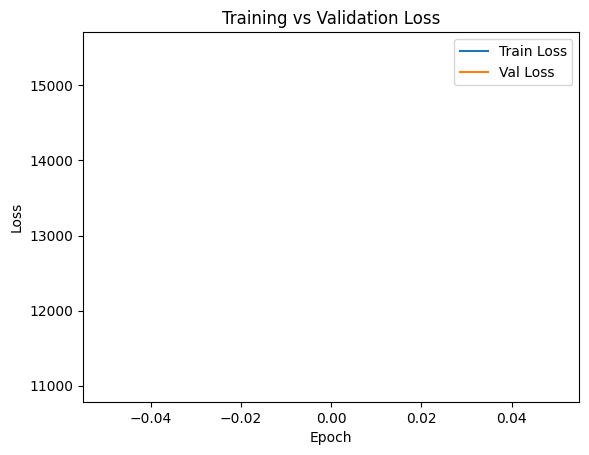

In [16]:

# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()